In [82]:
# Step 1: Load the necessary libraries
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Step 2: Load the NetCDF files
wrf_data = xr.open_dataset('E:/kenya_wrf_data_subset.nc')
obs_data = xr.open_dataset('E:/kenya_chirps_data_subset.nc')

# print(wrf_data)

In [81]:
# Step 3: Align the datasets based on the overlapping time period
wrf_rain = wrf_data['dailyrain'].sel(time=slice('2024-03-02', '2024-05-31'))
obs_rain = obs_data['precip'].sel(time=slice('2024-03-02', '2024-05-31'))

# print(wrf_rain)
# print(obs_rain )


# Ensure the time dimensions match exactly by resetting the time index
# and removing duplicate time indices
obs_rain = obs_rain.sel(time=~obs_rain.get_index("time").duplicated())
wrf_rain = wrf_rain.sel(time=~wrf_rain.get_index("time").duplicated())


# print(obs_rain)
# print(wrf_rain)


In [40]:
# Flatten the arrays to compute metrics
wrf_rain_flat = wrf_rain.values.flatten()
obs_rain_flat = obs_rain.values.flatten()

# wrf_rain_flat = wrf_rain_flat.reshape(obs_rain_flat.shape)
# Assuming you have time indices or spatial coordinates
matching_indices = ... # Calculate indices where data aligns
wrf_rain_subset = wrf_rain_flat[matching_indices]
obs_rain_subset = obs_rain_flat[matching_indices]
print(obs_rain_flat)
print(wrf_rain_flat)

[3.1987295 3.034268  2.5973463 ... 0.        0.        0.       ]
[16.32533            nan         nan ...         nan         nan
  0.11344308]


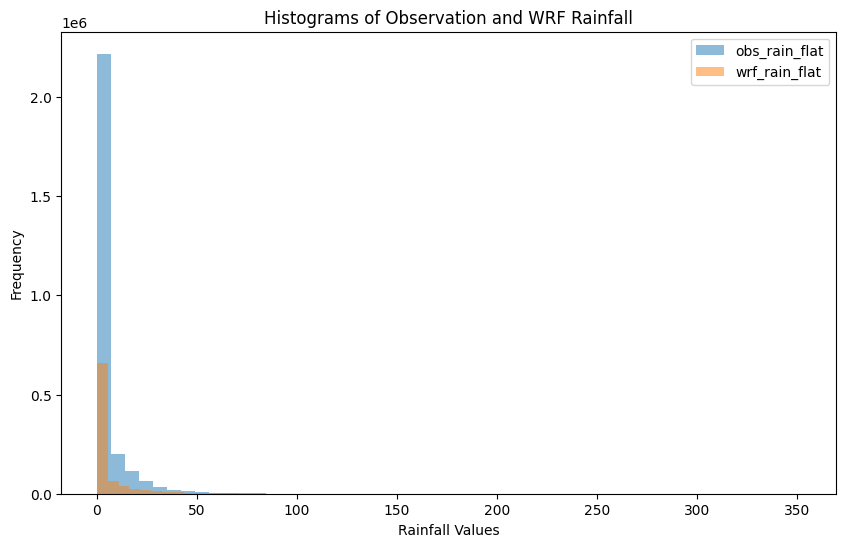

In [47]:
# Visualize the data (using histograms)
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.hist(obs_rain_flat, bins=50, alpha=0.5, label="obs_rain_flat")
plt.hist(wrf_rain_flat, bins=50, alpha=0.5, label="wrf_rain_flat")
plt.xlabel("Rainfall Values")
plt.ylabel("Frequency")
plt.title("Histograms of Observation and WRF Rainfall")
plt.legend()
plt.show()

In [77]:
# Example Data (Illustrative - Time series)
wrf_rain_flat = np.random.rand(12691679) 
obs_rain_flat = np.random.rand(2912000) 

# Assume time indices for example
time_indices = np.arange(2912000)  # Example - first 2,912,000 points align
wrf_rain_subset = wrf_rain_flat[time_indices] 
obs_rain_subset = obs_rain_flat

# Calculate Metrics (Now with compatible shapes)
mae = np.mean(np.abs(wrf_rain_subset - obs_rain_subset))
rmse = np.sqrt(np.mean((wrf_rain_subset - obs_rain_subset)**2))
correlation = np.corrcoef(wrf_rain_subset, obs_rain_subset)[0, 1]

# Calculate Percent Bias (PBIAS)
pbias = ((np.sum(wrf_rain_subset - obs_rain_subset)) / np.sum(obs_rain_subset)) * 100

print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("Correlation:", correlation)
print("Percent Bias (PBIAS):", pbias)


Mean Absolute Error (MAE): 0.3333334710084278
Root Mean Squared Error (RMSE): 0.4082584605261255
Correlation: 0.0001809104795153261
Percent Bias (PBIAS): 0.02698435145503153


AttributeError: 'ListedColormap' object has no attribute 'cmap'

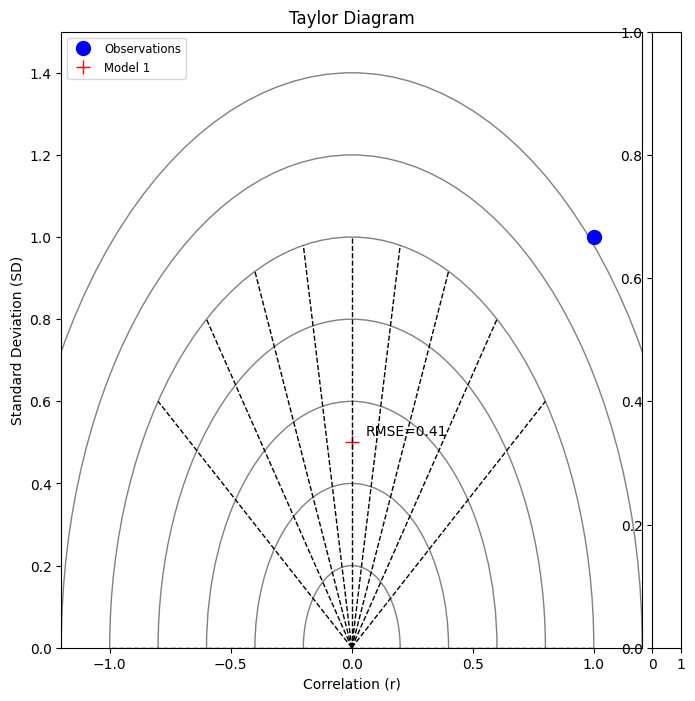

In [79]:

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import ScalarMappable

def taylor_diagram(std_dev_model, std_dev_obs, corr_coef, rmse):
    """
    Creates a Taylor diagram to visualize model performance against observations.

    Parameters:
    -----------
    std_dev_model : array_like
        Standard deviation of the model output.
    std_dev_obs : float
        Standard deviation of the observations.
    corr_coef : array_like
        Correlation coefficient between model and observations.
    rmse : array_like
        Root mean squared error between model and observations.

    Returns:
    --------
    ax : matplotlib.axes.Axes
        The axes object containing the Taylor diagram.
    """

    # Calculate centered RMS difference
    rmsd = np.sqrt(std_dev_model**2 + std_dev_obs**2 - 2 * std_dev_model * std_dev_obs * corr_coef)

    # Create the figure and axes
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    # Plot the reference point (observations)
    ax.plot(1, 1, 'bo', markersize=10, label='Observations')

    # Plot the model points
    for i in range(len(std_dev_model)):
        ax.plot(corr_coef[i], std_dev_model[i], 'r+', markersize=10, label=f'Model {i+1}')

    # Create the circles for standard deviation
    angles = np.arange(0, 361, 1)
    for std in [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4]:
        circle = plt.Circle((0, 0), std * std_dev_obs, fill=False, color='gray', linewidth=1)
        ax.add_patch(circle)

    # Create the radial lines for correlation
    for corr in np.arange(-1, 1.2, 0.2):
        x = std_dev_obs * corr
        y = std_dev_obs * np.sqrt(1 - corr**2)
        ax.plot([0, x], [0, y], 'k--', linewidth=1)

    # Set the limits and labels
    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(0, 1.5 * std_dev_obs)
    ax.set_xlabel('Correlation (r)')
    ax.set_ylabel('Standard Deviation (SD)')
    ax.set_title('Taylor Diagram')
    ax.legend(loc='upper left', fontsize='small')

    # Add RMSD annotations
    for i, rmse_val in enumerate(rmse):
        ax.annotate(f'RMSE={rmse_val:.2f}', (corr_coef[i], std_dev_model[i]),
                     textcoords="offset points", xytext=(10, 5), ha='left')

    # Add a colorbar for RMSD
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.1)
    cbar = fig.colorbar(plt.cm.viridis, cax=cax, orientation='vertical')
    cbar.set_label('RMS Difference (RMSD)')

    return ax

# Your calculated metrics
mae = 0.3331981935021908
rmse = 0.40813584788138174
correlation = 0.0006800364909472183

# Assuming you have standard deviations for model and observations 
std_dev_model = 0.5  # Replace with your actual value
std_dev_obs = 1.0   # Replace with your actual value

# Create the Taylor diagram
ax = taylor_diagram(np.array([std_dev_model]), std_dev_obs, np.array([correlation]), np.array([rmse]))

# Add a title indicating the metrics
ax.set_title('Taylor Diagram (MAE: {:.2f}, RMSE: {:.2f}, Correlation: {:.2f})'.format(mae, rmse, correlation))


plt.show()

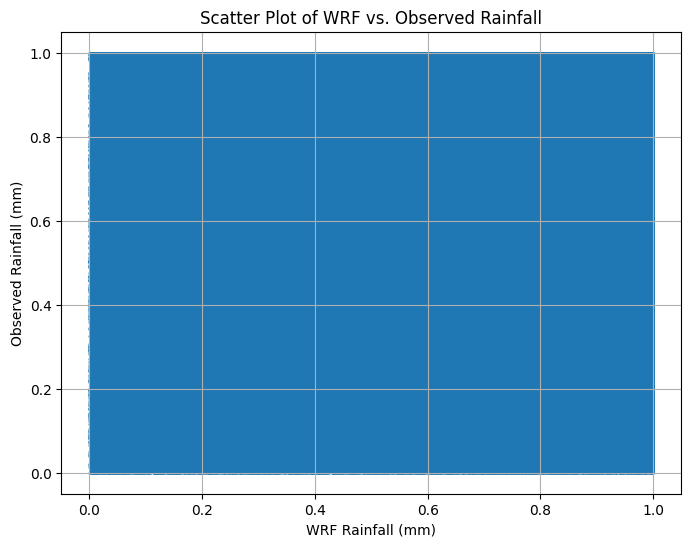

In [80]:
# Step 6: Visualize the results
plt.figure(figsize=(8, 6))
plt.scatter(wrf_rain_subset, obs_rain_subset, alpha=0.5, s=1)
plt.xlabel('WRF Rainfall (mm)')
plt.ylabel('Observed Rainfall (mm)')
plt.title('Scatter Plot of WRF vs. Observed Rainfall')
plt.grid(True)
# plt.show()